# Install packages

In [1]:
# Uncomment and run the cell to install packages
# !pip install numpy scipy scikit-learn matplotlib fairlearn POT

In [28]:
import numpy as np
from collections import namedtuple, Counter
import ot
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds, DemographicParity #, TruePositiveRateDifference
from fairlearn.metrics import group_recall_score, group_specificity_score
import matplotlib.pyplot as plt
import pickle
from numpy import linalg
from sklearn.base import BaseEstimator
from sklearn.metrics.pairwise import rbf_kernel
import multiprocessing
from joblib import Parallel, delayed
num_cores = min(25, multiprocessing.cpu_count())

np.random.seed(101)

In [3]:
import fairlearn
fairlearn.__version__

'0.4.1'

# Generate simulation data

In [4]:
def random_logit(x):
    z = 1./(1+np.exp(-x))
    s = np.random.binomial(n=1, p=z)

    return 2*s-1

def gen_synth_shift_data(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, C_src=0, C_tar=1, N=1000, verbose=False):
    '''Flu classification example
    Variables
    C: context 0 or 1
    A: age group 0 or 1
    R: risk
    T: temperature
    Y: flu 0 or 1'''
    
    # Regression coefficients
    gamma_AC = 0.2
    gamma_TC = 0.2

    gamma_RA = -0.1
    gamma_YA = -0.8
    gamma_YR = 0.8
    gamma_TY = 0.8
    gamma_TR = 0.1
    gamma_TA = -0.8
    
    scale_T = 1.0
    scale_e = 0.64
    scale_A = 1.0
    scale_Y = 1.0
    
    # Source datasets
    data_src = []
    for gamma_shift in gamma_shift_src:
        C_src_vec = np.repeat(a=C_src,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_src_vec + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1+scale_e, size=N) # N(0,1)
        Y_src = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        T = gamma_TY*Y_src + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=scale_T+gamma_shift*gamma_TC*C_src_vec, size=N)

        Y_src = (Y_src+1)/2
        X_src = np.stack([A, R, T], axis=1)
        data_src.append((gamma_shift,X_src,Y_src))

    # Target datasets
    data_tar = []
    for gamma_shift in gamma_shift_tar:
        C_tar_vec = np.repeat(a=C_tar,repeats=N)
        A = random_logit(scale_A*(gamma_A + gamma_shift*gamma_AC*C_tar_vec + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        R = gamma_RA*A + np.random.normal(loc=0.0, scale=1+scale_e, size=N)
        Y_tar = random_logit(scale_Y*(gamma_YA*A + gamma_YR*R + np.random.normal(loc=0.0, scale=scale_e, size=N)))
        T = gamma_TY*Y_tar + gamma_TR*R + gamma_TA*A + np.random.normal(loc=0.0, scale=scale_T+gamma_shift*gamma_TC*C_tar_vec, size=N)

        Y_tar = (Y_tar+1)/2
        X_tar = np.stack([A, R, T], axis=1)
        data_tar.append((gamma_shift,X_tar,Y_tar))
        
    sensible_feature = 0 # A
    non_separating_feature = 2 # T
    
    if verbose:
        print("Coefficients: g_shift:{},gA:{},gAC:{},gRA:{},gYA:{},gYR:{},gTC:{},gTY:{},gTR:{},gTA:{}"\
                  .format(gamma_shift, gamma_A, gamma_AC, gamma_RA, gamma_YA, gamma_YR, gamma_TC, gamma_TY, gamma_TR, gamma_TA))
    return data_src,data_tar,sensible_feature,non_separating_feature

def load_synth(data, target, data_test, target_test, smaller=False, scaler=True):
    len_train = len(data[:, -1])
    if scaler:
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
        data_test = scaler.transform(data_test)
    if smaller:
        print('A smaller version of the dataset is loaded...')
        data = namedtuple('_', 'data, target')(data[:len_train // 20, :-1], target[:len_train // 20])
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    else:
        data = namedtuple('_', 'data, target')(data, target)
        data_test = namedtuple('_', 'data, target')(data_test, target_test)
    return data, data_test

# Fairness measure

In [5]:
# Some of the code for calculating fairness metrics is taken from Fair ERM implementation https://github.com/jmikko/fair_ERM by Michele Donini
def equalized_odds_measure_TP(data, model, sensitive_features, ylabel, rev_pred=1):
    '''
    From https://github.com/jmikko/fair_ERM
    True positive label for the groups defined by the values of the "sensible_features",
    with respect to the "model" on the "data".
    :param data: the data where to evaluate the True Positive Rate (Equal Opportunity).
    :param model:  the model that has to be evaluated.
    :param sensitive_features: the features used to split the data in groups.
    :param ylabel: the POSITIVE label (usually +1).
    :param rev_pred: an option to reverse the outputs of our model.
    :return: a dictionary with keys the sensitive_features and values dictionaries containing the True Positive Rates
    of the different subgroups of the specific sensitive feature.
    '''
    predictions = model.predict(data.data) * rev_pred
    truth = data.target
    eq_dict = {}
    for feature in sensitive_features:
        eq_sensible_feature = {}
        values_of_sensible_feature = list(set(data.data[:, feature]))
        for val in values_of_sensible_feature:
            eq_tmp = None
            positive_sensitive = np.sum([1.0 if data.data[i, feature] == val and truth[i] == ylabel else 0.0
                                         for i in range(len(predictions))])
            if positive_sensitive > 0:
                eq_tmp = np.sum([1.0 if predictions[i] == ylabel and data.data[i, feature] == val and truth[i] == ylabel
                                 else 0.0 for i in range(len(predictions))]) / positive_sensitive
            eq_sensible_feature[val] = eq_tmp
        eq_dict[feature] = eq_sensible_feature
    return eq_dict

def max_equalized_odds_violation(target, predictions, sensitive_feature):
    '''
    Maximum violation of equalized odds constraint. From fair reductions paper,
    max_{y,a} |E[h(X)|Y=y,A=a]-E[h(X)|Y=y]|
    :param sensitive_feature: actual value of the sensitive feature
    '''
    tpr = group_recall_score(target, predictions, sensitive_feature)
    specificity = group_specificity_score(target, predictions, sensitive_feature) # 1-fpr
    
    max_violation = max([abs(tpr_group-tpr.overall) for tpr_group in tpr.by_group.values()] +
        [abs(spec_group-specificity.overall) for spec_group in specificity.by_group.values()])
    
    return max_violation

# Classifiers and Train-Test Loop

In [25]:
def standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    '''
    Standard with Logistic Regression -  Train logistic regression using all features in training set
    '''
    if verbose:
        print('\n\nNo fairness contraint')

    clf_std = LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True)
    clf_std.fit(dataset_train.data, dataset_train.target)
    
    # Accuracy measures
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(dataset_train.data)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(dataset_train.data)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)

    # Fairness measures
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

def weighted_score(dataset, algorithm):
    pred_all = np.zeros((dataset.data.shape[0],len(algorithm._classifiers)))
    for i,clf in enumerate(algorithm._classifiers):
        pred_all[:,i] = clf.predict_proba(dataset.data)[:,1]

    score = pred_all.dot(algorithm._expgrad_result._weights)

    return score

def fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose):
    '''
    Using fairlearn https://github.com/fairlearn/fairlearn
    '''
    list_of_sensible_feature_test = dataset_test.data[:, sensible_feature]
    if verbose:
        print('\n\nWith fairness constraint')

    algorithm = ExponentiatedGradient(
            LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True),
#             constraints=EqualizedOdds(),
            constraints=DemographicParity(),
            eps=0.01,
            T=50,
            nu=1e-6)

    algorithm.fit(
        dataset_train.data,
        dataset_train.target,
        sensitive_features=dataset_train.data[:, sensible_feature])
    
    if verbose:
        print('Best Fair Estimator::', algorithm.estimator)

    # Accuracy measures
    pred = algorithm.predict(dataset_test.data)
    pred_train = algorithm.predict(dataset_train.data)
    score = weighted_score(dataset_test, algorithm)
    score_train = weighted_score(dataset_train, algorithm)
    acc_test_fair = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train_fair = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test fair:', acc_test_fair)
        print('Accuracy train fair:', acc_train_fair)

    # Fairness measures
    max_DEOd_train_fair = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test_fair = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, algorithm, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, algorithm, [sensible_feature], ylabel=1)
    DEO_test_fair = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train_fair = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test_fair)
        print('DEO train:', DEO_train_fair)
        
    return DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair

def predict_test(clf,gamma,Xapp,Xtest):
    Kx=classif.rbf_kernel(Xtest,Xapp,gamma=gamma)
    return clf.predict(Kx)

def ot_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose):
    '''
    Standard Optimal Transport with Logistic Regression -  Train on transformed features
    '''
    if verbose:
        print('\n\nOptimal transport. No fairness contraint')

    Xs = dataset_train.data
    ys = dataset_train.target
    Xt = dataset_test.data
    M = ot.dist(Xs, Xt, metric='sqeuclidean')

    # Sinkhorn Transport with Group lasso regularization
    ot_lpl1 = ot.da.SinkhornLpl1Transport(reg_e, reg_cl)
    ot_lpl1.fit(Xs=Xs, ys=ys, Xt=Xt)
    
    transp_Xs_lpl1 = ot_lpl1.transform(Xs=Xs)

    clf_std = LogisticRegression(solver='liblinear', C=1.0, fit_intercept=True)
    clf_std.fit(transp_Xs_lpl1, dataset_train.target)
    
    # Accuracy measures
    pred = clf_std.predict(dataset_test.data)
    pred_train = clf_std.predict(transp_Xs_lpl1)
    score = clf_std.decision_function(dataset_test.data)
    score_train = clf_std.decision_function(transp_Xs_lpl1)
    acc_test = [roc_auc_score(dataset_test.target, score),\
                average_precision_score(dataset_test.target, score),\
                accuracy_score(dataset_test.target, pred)]
    acc_train = [roc_auc_score(dataset_train.target, score_train),\
                average_precision_score(dataset_train.target, score_train),\
                 accuracy_score(dataset_train.target, pred_train)]
    if verbose:
        print('Predicted class ratio test:', Counter(pred)[1]/len(pred))
        print('Accuracy test:', acc_test)
        print('Accuracy train:', acc_train)

    # Fairness measures
    max_DEOd_train = max_equalized_odds_violation(dataset_train.target, pred_train, dataset_train.data[:, sensible_feature])
    max_DEOd_test = max_equalized_odds_violation(dataset_test.target, pred, dataset_test.data[:, sensible_feature])
    EO_train = equalized_odds_measure_TP(dataset_train, clf_std, [sensible_feature], ylabel=1)
    EO_test = equalized_odds_measure_TP(dataset_test, clf_std, [sensible_feature], ylabel=1)
    DEO_test = np.abs(EO_test[sensible_feature][sensible_feature_values[0]] -
                              EO_test[sensible_feature][sensible_feature_values[1]])
    DEO_train = np.abs(EO_train[sensible_feature][sensible_feature_values[0]] -
                               EO_train[sensible_feature][sensible_feature_values[1]])
    if verbose:
        print('DEO test:', DEO_test)
        print('DEO train:', DEO_train)
        
    return DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train

# One run of 4 classifiers with multiple test datasets
def single_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, C_src, C_tar, N, CV_FOLDS,\
                            run=0, outdir='./results', verbose=False):
    
    # Generate source (train) and target (test) datasets
    data_src,data_tar,sensible_feature,non_separating_feature = gen_synth_shift_data(gamma_shift_src, gamma_shift_tar, gamma_A, C_src, C_tar, N)
    
    # Format of data_src: [(gamma_shift, X, Y),]
    _,X,Y = data_src[0] # only considers 1st data
    
    all_res = []
    for (gamma_shift,X_test,Y_test) in data_tar:
        print("\nShift", gamma_shift)

        dataset_train, dataset_test = load_synth(X, Y, X_test, Y_test, smaller=False, scaler=True)
        
        sensible_feature_values = sorted(list(set(dataset_train.data[:, sensible_feature])))
        
        A_tmp = dataset_test.data[:, sensible_feature]
        sensible_feature_ratio = Counter(A_tmp)[max(A_tmp)]/len(A_tmp) # larger sensitive feature value
        class_ratio = Counter(dataset_test.target)[1]/len(dataset_test.target)
        ntrain = len(dataset_train.target)
        
        if verbose:
            print('Different values of the sensible feature', sensible_feature, ':', sensible_feature_values)
            print('Number of examples in each level of the sensible feature', sensible_feature, ':',\
                  Counter(dataset_train.data[:, sensible_feature]), Counter(dataset_test.data[:, sensible_feature]),\
                  'test ratio:', [(x,y/len(dataset_test.data)) for (x,y) in Counter(dataset_test.data[:, sensible_feature]).items()])
            print('Number of examples in each class in train:',\
                  Counter(dataset_train.target), 'test:', Counter(dataset_test.target),\
                  'test ratio:', [(x,y/len(dataset_test.target)) for (x,y) in Counter(dataset_test.target).items()])
            print('Sensible feature ratio test', sensible_feature_ratio)
            print('Class ratio test:', class_ratio)

        # Standard Logistic Regression
        DEO_test, DEO_train, acc_test, acc_train, max_DEOd_test, max_DEOd_train = standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        # Standard Logistic Regression with FairLearn
        DEO_test_fair, DEO_train_fair, acc_test_fair, acc_train_fair, max_DEOd_test_fair, max_DEOd_train_fair = fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
            
        # Standard Optimal Transport with Logistic Regression
        reg_e = 1e1
        reg_cl = 1e-2
        DEO_test_ot, DEO_train_ot, acc_test_ot, acc_train_ot, max_DEOd_test_ot, max_DEOd_train_ot = ot_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, reg_e, reg_cl, verbose)
        
        # Keep only separating features
        newdata = dataset_train.data
        newdata = np.delete(newdata, non_separating_feature, 1)
        dataset_train = namedtuple('_', 'data, target')(newdata, dataset_train.target)
        newdata = dataset_test.data
        newdata = np.delete(newdata, non_separating_feature, 1)
        dataset_test = namedtuple('_', 'data, target')(newdata, dataset_test.target)
        if sensible_feature >= non_separating_feature:
            sensible_feature = sensible_feature-1 # only if sensible_feature comes after removed feature

        # Standard Logistic Regression with separating features
        DEO_test_sep, DEO_train_sep, acc_test_sep, acc_train_sep, max_DEOd_test_sep, max_DEOd_train_sep = standard_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)
        
        # Standard Logistic Regression with separating features and FairLearn
        DEO_test_sep_fair, DEO_train_sep_fair, acc_test_sep_fair, acc_train_sep_fair, max_DEOd_test_sep_fair, max_DEOd_train_sep_fair = fair_classifier(dataset_train, dataset_test, sensible_feature_values, sensible_feature, CV_FOLDS, verbose)

        res = (gamma_shift,
               {'SVC':{'fair_test':DEO_test, 'fair_train':DEO_train,
                        'roc_auc_test':acc_test[0],'roc_auc_train':acc_train[0],
                        'auprc_test':acc_test[1], 'auprc_train':acc_train[1],
                        'acc_test':acc_test[2], 'acc_train':acc_train[2],
                        'maxDEOd_test':max_DEOd_test, 'maxDEOd_train':max_DEOd_train},
                'OT':{'fair_test':DEO_test_ot, 'fair_train':DEO_train_ot,
                        'roc_auc_test':acc_test_ot[0],'roc_auc_train':acc_train_ot[0],
                        'auprc_test':acc_test_ot[1], 'auprc_train':acc_train_ot[1],
                        'acc_test':acc_test_ot[2], 'acc_train':acc_train_ot[2],
                        'maxDEOd_test':max_DEOd_test_ot, 'maxDEOd_train':max_DEOd_train_ot},
                'Fair_SVC':{'fair_test':DEO_test_fair, 'fair_train':DEO_train_fair,
                            'roc_auc_test':acc_test_fair[0], 'roc_auc_train':acc_train_fair[0],
                            'auprc_test':acc_test_fair[1], 'auprc_train':acc_train_fair[1],
                            'acc_test':acc_test_fair[2], 'acc_train':acc_train_fair[2],
                            'maxDEOd_test':max_DEOd_test_fair, 'maxDEOd_train':max_DEOd_train_fair},
                'SVC_Sep_Feats':{'fair_test':DEO_test_sep, 'fair_train':DEO_train_sep,
                                 'roc_auc_test':acc_test_sep[0], 'roc_auc_train':acc_train_sep[0],
                                 'auprc_test':acc_test_sep[1], 'auprc_train':acc_train_sep[1],
                                 'acc_test':acc_test_sep[2], 'acc_train':acc_train_sep[2],
                                'maxDEOd_test':max_DEOd_test_sep, 'maxDEOd_train':max_DEOd_train_sep},
               'Fair_SVC_Sep_Feats':{'fair_test':DEO_test_sep_fair, 'fair_train':DEO_train_sep_fair,
                                     'roc_auc_test':acc_test_sep_fair[0], 'roc_auc_train':acc_train_sep_fair[0],
                                     'auprc_test':acc_test_sep_fair[1], 'auprc_train':acc_train_sep_fair[1],
                                     'acc_test':acc_test_sep_fair[2], 'acc_train':acc_train_sep_fair[2],
                                    'maxDEOd_test':max_DEOd_test_sep_fair, 'maxDEOd_train':max_DEOd_train_sep_fair}},
                sensible_feature_ratio, class_ratio)
        
        all_res.append(res)
        
        # Save after every shift
        with open('{}/synthetic_res_intm_gamma_shift_N_{}_R_{}_run_{}.pickle'.format(outdir,N,R,run), 'wb') as fw:
            pickle.dump(all_res, fw)
        
    # No changes to all_res to use last saved file
    print('End run', run)

    return all_res

def experiment_shift(gamma_shift_src=[0.0], gamma_shift_tar=[0.0], gamma_A=0.0, N=1000, R=10, CV_FOLDS=4,\
                     methods=['SVC'], metrics=['roc_auc_test'], outdir='./results', parallel=False, verbose=False):
    '''
    Run train-test loop multiple times and collect results
    '''
    all_res = []
    all_shift = np.empty((len(gamma_shift_tar),R))
    all_sensible_feature_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    all_class_ratio = np.empty((len(gamma_shift_tar),R)) # for positive
    
    # Format: {method: {metric: [shift, run]}
    res_all_runs = dict()
    
    # Initialize matrix to store metrics
    for method in methods:
        for metric in metrics:
            if method not in res_all_runs:
                res_all_runs[method] = dict()
            nan_mat = np.empty((len(gamma_shift_tar),R)) # TODO: shifts assumed in same order as in gamma_shift_tar
            nan_mat[:] = np.nan
            res_all_runs[method][metric] = nan_mat
            
    # Run repeatedly in parallel
    if parallel:
        print('\nStart parallel runs on {} cores'.format(num_cores))
        Parallel(n_jobs=num_cores)(delayed(single_experiment_shift)(gamma_shift_src, gamma_shift_tar, gamma_A,\
                                                    C_src, C_tar, N, CV_FOLDS, run, outdir, verbose) for run in range(R))
        
    for run in range(R):
        print("\nRun", run)
        
        if parallel:
            # Read saved parallel runs
            with open('{}/synthetic_res_intm_gamma_shift_N_{}_R_{}_run_{}.pickle'.format(outdir,N,R,run), 'rb') as fr:
                shift_res_single_run = pickle.load(fr)
        else:
            # Run sequentially
            shift_res_single_run = single_experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A,\
                                                           C_src, C_tar, N, CV_FOLDS, run, outdir, verbose)

        shift_id = 0
        for (gamma_shift, res_single_run, sf_ratio, class_ratio) in shift_res_single_run:
            
            for method in methods:
                for metric in metrics:
                    res_all_runs[method][metric][shift_id,run] = res_single_run[method][metric]

            all_shift[shift_id,run] = gamma_shift
            all_sensible_feature_ratio[shift_id,run] = sf_ratio
            all_class_ratio[shift_id,run] = class_ratio
            
            shift_id+=1
            
        all_res.append(shift_res_single_run)

        if verbose:
            print(shift_res_single_run)

    if True:
        print("\nShift gamma mean, std, min, max:",\
              np.mean(all_shift, axis=1), np.std(all_shift, axis=1),\
              np.min(all_shift, axis=1), np.max(all_shift, axis=1))

        print("Sensitive feature ratio mean, std, min, max:",\
              np.mean(all_sensible_feature_ratio, axis=1), np.std(all_sensible_feature_ratio, axis=1),\
              np.min(all_sensible_feature_ratio, axis=1), np.max(all_sensible_feature_ratio, axis=1))

        print("\nClass ratio mean, std, min, max:",\
              np.mean(all_class_ratio, axis=1), np.std(all_class_ratio, axis=1),\
              np.min(all_class_ratio, axis=1), np.max(all_class_ratio, axis=1))
        
    with open('{}/synthetic_res_all_gamma_shift_N_{}_R_{}.pickle'.format(outdir,N,R), 'wb') as fw:
        pickle.dump(res_all_runs, fw)
        pickle.dump(all_res, fw)

    return res_all_runs

# Visualize accuracy and fairness measures

In [38]:
def scatter_metric_fair(res_dict, methods, acc_metric, fair_metric, gamma_shift, gamma_shift_index,\
                        xylim, xlabel, ylabel, filename, outdir):
    acc_array = []
    fair_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric][gamma_shift_index,:])
        fair_array.append(res_dict[method][fair_metric][gamma_shift_index,:])
    
    acc_array = np.array(acc_array)
    fair_array = np.array(fair_array)
    
    mean_acc = np.median(acc_array, axis=1)
    mean_fair = np.median(fair_array, axis=1)
    quartile_acc = np.percentile(acc_array, [25, 75], axis=1)
    quartile_fair = np.percentile(fair_array, [25, 75], axis=1)
    error_acc = quartile_acc.copy()
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    error_fair = quartile_fair.copy()
    error_fair[0,:] = mean_fair - error_fair[0,:] # lower error
    error_fair[1,:] = error_fair[1,:] - mean_fair # upper error
    
    colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', 'D', '^')
    groups = ('Standard', 'Causal DA', 'OT DA',\
            'Standard w. FairLearn', 'Causal DA w. FairLearn')

    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10

    for x, y, color, shape, group in zip(mean_acc, mean_fair, colors, shapes, groups):
        plt.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=160, marker=shape, label=group)
    
    plt.errorbar(mean_acc, mean_fair, yerr=error_fair, xerr=error_acc, capsize=2, fmt='none', ecolor='black', elinewidth=0.5)

    plt.xlabel(xlabel+' on Target Data')
    plt.ylabel(ylabel+' on Target Data')
    plt.axis(xylim)

    plt.legend(loc=2, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('{}/synthetic_{}_fair_gamma_shift_N_{}_R_{}_g_{}.pdf'.format(outdir,filename, N, R, gamma_shift))
    
def scatter_metric_shift(res_dict, methods, methods_plot, acc_metric, gamma_shift_arr,\
                         ylim, label, filename, outdir):
    acc_array = []
    for method in methods:
        acc_array.append(res_dict[method][acc_metric])
    
    # Format: [method, shift, run]
    acc_array = np.array(acc_array)

    mean_acc = np.median(acc_array, axis=2) # Format: [method, shift]
    quartile_acc = np.percentile(acc_array, [25, 75], axis=2)
    error_acc = quartile_acc.copy() # Format: [2, method, shift]
    error_acc[0,:] = mean_acc - error_acc[0,:] # lower error
    error_acc[1,:] = error_acc[1,:] - mean_acc # upper error
    
    colors = ('#1A85FF', '#FE6100', '#FFB000', '#785EF0', '#D41159')
    shapes = ('s', 'v', 'o', 'D', '^')
    groups = ('Standard', 'Causal DA', 'OT DA',\
            'Standard w. FairLearn', 'Causal DA w. FairLearn')
    
    plt.figure(figsize=(5, 5))
    plt.rcParams['font.size'] = 15
    plt.rcParams['legend.fontsize'] = 10
    
    print('Median\n',mean_acc)
    
    for m_id, color, shape, group in zip(range(len(methods)), colors, shapes, groups):
        if m_id in methods_plot:
            plt.plot(gamma_shift_arr, mean_acc[m_id,:], '-', color=color, marker=shape, label=group)
            plt.errorbar(gamma_shift_arr, mean_acc[m_id,:], yerr=error_acc[:,m_id,:], capsize=2, fmt='none', ecolor='black', elinewidth=0.5)

    plt.xlabel('Magnitude of Shift')
    plt.ylabel(label+' on Target Data')
    plt.ylim(ylim)

    plt.legend(loc=1, fancybox=True, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('{}/synthetic_{}_all_gamma_shift_N_{}_R_{}.pdf'.format(outdir,filename, N, R))

# Main - Accuracy and fairness for different shifts

In [29]:
gamma_A=0.0
C_src=0
C_tar=1
N=2000
R=10 
# R=50 # Uncomment for Fig 1 in supplementary
CV_FOLDS=4 # Not used
OUTDIR='./results_synth'
PARALLEL=True

gamma_shift_src = [0.0]
gamma_shift_tar = [1.0,5.0,10.0]
# gamma_shift_tar =  np.linspace(0,15,10) # Uncomment for Fig 1 in supplementary

methods = ['SVC','SVC_Sep_Feats','OT','Fair_SVC','Fair_SVC_Sep_Feats']
metrics = ['roc_auc_test','auprc_test','acc_test','fair_test','maxDEOd_test','roc_auc_train','auprc_train','acc_train','fair_train','maxDEOd_train']

# Format: {method: {metric: [shift, run]}
all_shift_res = experiment_shift(gamma_shift_src, gamma_shift_tar, gamma_A, N, R, CV_FOLDS, methods, metrics,\
                                 OUTDIR, PARALLEL, verbose=False)


Start parallel runs on 25 cores

Run 0

Run 1

Run 2

Run 3

Run 4

Run 5

Run 6

Run 7

Run 8

Run 9

Shift gamma mean, std, min, max: [ 1.  5. 10.] [0. 0. 0.] [ 1.  5. 10.] [ 1.  5. 10.]
Sensitive feature ratio mean, std, min, max: [0.5528 0.7178 0.8672] [0.01007274 0.0139807  0.00827103] [0.5395 0.695  0.854 ] [0.568 0.74  0.882]

Class ratio mean, std, min, max: [0.48315 0.4286  0.3891 ] [0.00886862 0.00834506 0.01377461] [0.4705 0.4165 0.356 ] [0.497  0.448  0.4055]


## Figures 1a, 1b in main text

Median
 [[0.8075  0.726   0.665  ]
 [0.72775 0.738   0.735  ]
 [0.7895  0.6995  0.67125]
 [0.7555  0.68325 0.638  ]
 [0.6855  0.68725 0.6895 ]]


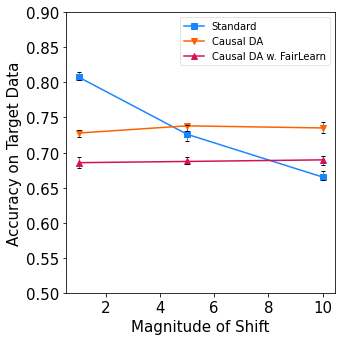

In [39]:
methods_plot = [0,1,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'acc_test', gamma_shift_tar, (0.5,0.9), 'Accuracy', 'acc_3', OUTDIR)

Median
 [[0.1117931  0.12520086 0.10687297]
 [0.2659066  0.32484367 0.32069851]
 [0.03556787 0.11197184 0.19969575]
 [0.12323436 0.11086673 0.11229144]
 [0.0728659  0.08707701 0.1019158 ]]


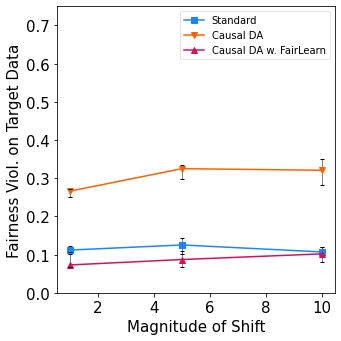

In [40]:
methods_plot = [0,1,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_test', gamma_shift_tar, (0.0,0.75), 'Fairness Viol.', 'mDEO_fair_3', OUTDIR)

## Figures 4a, 4b in main text

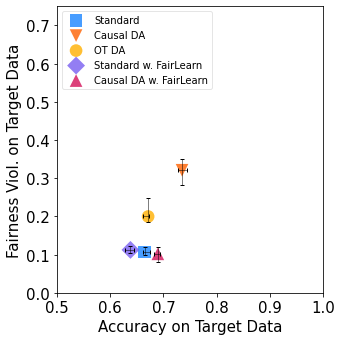

In [41]:
xylim = (0.5,1.0,0.0,0.75)
scatter_metric_fair(all_shift_res, methods, 'acc_test', 'maxDEOd_test', gamma_shift_tar[-1], -1, xylim, 'Accuracy', 'Fairness Viol.', 'acc_maxDEOd_high', OUTDIR)

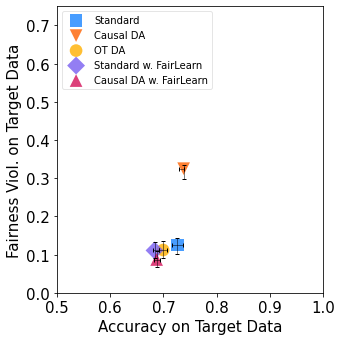

In [42]:
xylim = (0.5,1.0,0.0,0.75)
scatter_metric_fair(all_shift_res, methods, 'acc_test', 'maxDEOd_test', round(gamma_shift_tar[1],2), 1, xylim, 'Accuracy', 'Fairness Viol.', 'acc_maxDEOd_low', OUTDIR)

## Figures 1a, 1b, 1c in supplementary

Median
 [[0.8075  0.726   0.665  ]
 [0.72775 0.738   0.735  ]
 [0.7895  0.6995  0.67125]
 [0.7555  0.68325 0.638  ]
 [0.6855  0.68725 0.6895 ]]


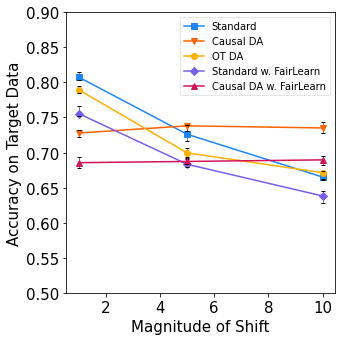

In [43]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'acc_test', gamma_shift_tar, (0.5,0.9), 'Accuracy', 'acc', OUTDIR)

Median
 [[0.89377933 0.79947771 0.71964447]
 [0.80589103 0.80648855 0.79395307]
 [0.87606049 0.77835125 0.7385432 ]
 [0.84164931 0.75859451 0.70054938]
 [0.75069596 0.76700017 0.7659702 ]]


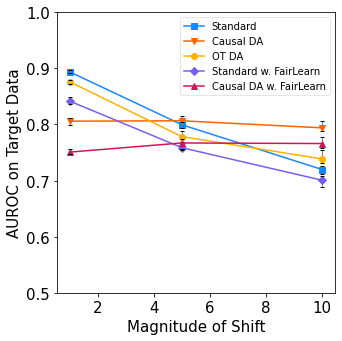

In [44]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'roc_auc_test', gamma_shift_tar, (0.5,1.0), 'AUROC', 'roc_auc', OUTDIR)

Median
 [[0.1117931  0.12520086 0.10687297]
 [0.2659066  0.32484367 0.32069851]
 [0.03556787 0.11197184 0.19969575]
 [0.12323436 0.11086673 0.11229144]
 [0.0728659  0.08707701 0.1019158 ]]


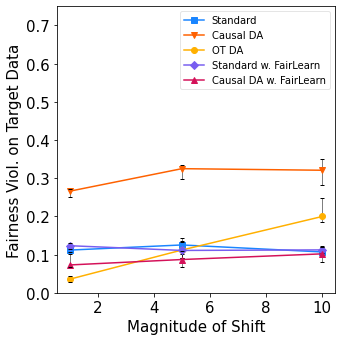

In [45]:
methods_plot = [0,1,2,3,4]
scatter_metric_shift(all_shift_res, methods, methods_plot, 'maxDEOd_test', gamma_shift_tar, (0.0,0.75), 'Fairness Viol.', 'mDEO_fair', OUTDIR)